In [1]:
# !pip install transformers datasets nltk
# !pip install torch torchvision torchaudio
# !pip install sentencepiece scikit-learn
# !pip install sacrebleu pandas numpy
# !pip install rouge_score
# !pip install py7zr

In [2]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = torch.device("mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-14.5-arm64-arm-64bit
PyTorch Version: 2.4.0

Python 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.5.1
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


### CNN/Daily Mail Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset('cnn_dailymail', '3.0.0')
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [ ]:
sample = dataset['train'][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [ ]:
sample_text = dataset['train'][1]['article'][:2000]
summaries = {}

In [4]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishabharya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries['baseline'] = three_sentence_summary(sample_text)

### GPT-2

In [ ]:
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline('text-generation',model='gpt2-xl',device=device)
gpt2_query = sample_text + '\nTL;DR:\n'
pipe_out = pipe(gpt2_query,max_length=512,clean_up_tokenization_spaces=True)
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) : ]))

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### T5

In [ ]:
pipe = pipeline('summarization',model='t5-large',device=device)
pipe_out = pipe(sample_text)
summaries['t5'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

### BART

In [ ]:
pipe = pipeline('summarization',model='facebook/bart-large-cnn',device=device)
pipe_out = pipe(sample_text)
summaries['bart'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### PEGASUS

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail",device=device)
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace("<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## Comparing different Summaries

In [ ]:
print("GROUND TRUTH")
print(dataset['train'][1]['highlights'])
print("")
for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
The mentally ill aren't being properly treated and are more likely to be arrested than not if you look at the statistics on the ninth floor of the pretrial detention center in Miami-Dade County.

T5
mentally ill inmate

## Measuring the quality of generated text

#### BLEU

In [4]:
from datasets import load_metric
bleu_metric = load_metric('sacrebleu')

<ipython-input-4-5285f4af4e76>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('sacrebleu')


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference = ["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method='floor',smooth_value = 0)
results['precisions'] = [np.round(p,2) for p in results['precisions']]
pd.DataFrame.from_dict(results,orient='index',columns=['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [5]:
rouge_metric = load_metric('rouge')

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
reference = dataset['train'][1]['highlights']
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.305882,0.096386,0.188235,0.258824
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.326531,0.208333,0.285714,0.326531


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [ ]:
def evaluate_summaries_baseline(dataset,metric,column_text='article',column_summary='highlights'):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset['test'].shuffle(seed=42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled,rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict,orient='index',columns=['baseline']).T


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [6]:
from tqdm import tqdm
import torch


def chunks(list_of_elements,batch_size):
  for i in range(0,len(list_of_elements),batch_size):
    yield list_of_elements[i:i+batch_size]

def evaluate_summaries_pegasus(dataset,metric,model,tokenizer,batch_size=16,device=device,column_text='article',column_summary='highlights'):
  article_batches = list(chunks(dataset[column_text],batch_size))
  target_batches = list(chunks(dataset[column_summary],batch_size))
  print(len(article_batches),len(article_batches[0]))

  for article_batch,target_batch in tqdm(zip(article_batches,target_batches),total=len(article_batches)):
    inputs = tokenizer(article_batch,max_length=1024,truncation=True,padding='max_length',return_tensors='pt')
    summaries = model.generate(input_ids=inputs['input_ids'].to(device),attention_mask=inputs['attention_mask'].to(device),
                               length_penalty=0.8,num_beams=8,max_length=128)
    decoded_summaries = [tokenizer.decode(s,skip_special_tokens=True,clean_up_tokenization_spaces=True) for s in summaries]
    decoded_summaries = [d.replace("<n>"," ") for d in decoded_summaries]
    metric.add_batch(predictions=decoded_summaries,references=target_batch)

  score = metric.compute()
  return score


In [ ]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

model_ckpt = 'google/pegasus-cnn_dailymail'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled,rouge_metric,model,tokenizer,batch_size=2)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


500 2


100%|██████████| 500/500 [37:18<00:00,  4.48s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict,index=['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


## Training a Summarization Model

In [4]:
dataset_samsum = load_dataset('samsum')
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum['test'][1]['dialogue'])

print("\nSummary:")
print(dataset_samsum['test'][1]['summary'])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail",device=device)
pipe_out = pipe(dataset_samsum['test'][1]['dialogue'])
print("Summary:")
print(pipe_out[0]['summary_text'].replace(" .<n>",".\n"))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary:
Eric: Machine! Rob: Machine! Eric: Machine! Rob: TTYL?<n>Rob: Sure!<n>Eric: Gr8! I'll watch them now!<n>Rob: Me too! Eric: Machine! Rob: Machine! Eric: TTYL?


In [ ]:
import torch
import gc

# ... your code ...

# Free up GPU memory
del model  # Delete the model if you're done with it
torch.cuda.empty_cache()
gc.collect()

# ... continue with other operations ...

47

In [8]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

model_ckpt = 'google/pegasus-cnn_dailymail'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum['test'],rouge_metric,model,tokenizer,
                                   column_text='dialogue',column_summary='summary',batch_size=1)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict,index=['pegasus'])

819 1


100%|██████████| 819/819 [27:16<00:00,  2.00s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296539,0.087816,0.229112,0.229335


### Fine-Tuning PEGASUS

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


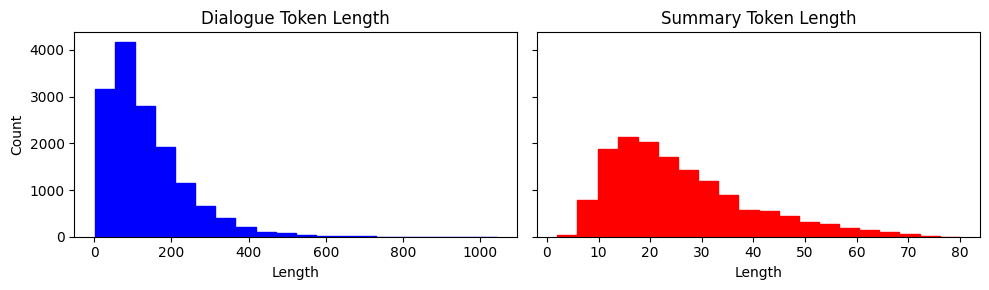

In [ ]:
from matplotlib import pyplot as plt
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]

fig,axes = plt.subplots(1,2,figsize=(10,3),sharey=True)
axes[0].hist(d_len,bins=20,color='blue',edgecolor='blue')
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len,bins=20,color='red',edgecolor='red')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [9]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [10]:
from huggingface_hub import notebook_login

notebook_login()

In [11]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer,model=model)

training_args = TrainingArguments(
    output_dir='pegasus-samsum',num_train_epochs=1,warmup_steps=500,
    per_device_train_batch_size=1,per_device_eval_batch_size=1,
    weight_decay=0.01,logging_steps=10,
    evaluation_strategy='steps',eval_steps=500,save_steps=1e6,
    gradient_accumulation_steps=16,push_to_hub=True,push_to_hub_model_id="pegasus-samsum-fine-tuned"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1980: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case thundergod-zenitsu/pegasus-samsum-fine-tuned).
  warnings.warn(


In [12]:
trainer = Trainer(model=model,args=training_args,
                  tokenizer=tokenizer,data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'],
                  eval_dataset=dataset_samsum_pt['validation'])

In [13]:
trainer.train()
score = evaluate_summaries_pegasus(dataset_samsum['test'],rouge_metric,trainer.model,tokenizer,batch_size=1,
                                   column_text='dialogue',column_summary='summary')
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict,index=['pegasus'])

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.659900,1.483296


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


819 1


100%|██████████| 819/819 [19:51<00:00,  1.46s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.43014,0.202499,0.343201,0.343243


In [14]:
trainer.push_to_hub("Training complete!")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


CommitInfo(commit_url='https://huggingface.co/thundergod-zenitsu/pegasus-samsum-fine-tuned/commit/0254dafc075ee898ccb4ce708a288b85d20a9889', commit_message='Training complete!', commit_description='', oid='0254dafc075ee898ccb4ce708a288b85d20a9889', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from transformers import pipeline
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="thundergod-zenitsu/pegasus-samsum-fine-tuned",device=device)


In [7]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [8]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
